In [ ]:
## メディア演習1 画像情報処理　0 まずは説明
## 画像のカメラからの取り込みとそのコピー
## まずはこれをよく理解すること

import numpy as np
import cv2
import matplotlib.pyplot as plt
import IPython
import time

In [ ]:
# カメラオープン
# cap = cv2.VideoCapture(1)

# カメラを使えない場合はこちら
# 自動ループしないので，ビデオが終了したあとはこのセルを再実行すること
cap = cv2.VideoCapture("fukei.mp4")

In [ ]:
## 結果・入力画像表示用の関数
## 必要に応じて書き換え
## 今回は基本的には書き換える必要はない

def update_disp(disp,image):
    _, enc = cv2.imencode(".jpg",image)
    disp.update(IPython.display.Image(data=enc.tobytes()))

## 何も表示しないためのプロセス
def zero(src, args=[]):
    return np.zeros(src.shape, dtype=np.uint8)

def image_show(process=zero, args=[]):
    ## 入力画像表示用ディスプレイ
    disp = IPython.display.display("Input",display_id=1)
    ## 結果画像表示用ディスプレイ
    disp2 = IPython.display.display("Result",display_id = 2)
    while cap.isOpened():
        try:
            ret, frame = cap.read()
            if ret is False:
                break
            # 入力画像と結果画像の表示を更新
            update_disp(disp,frame)
            update_disp(disp2, process(frame, args))
            time.sleep(1.0/30)

        except KeyboardInterrupt:
            break


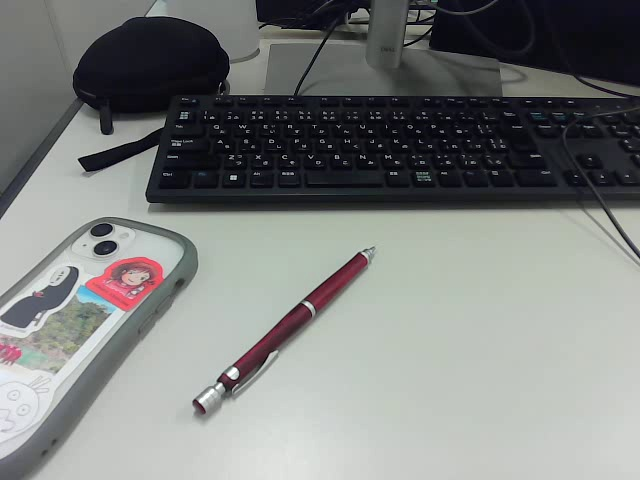

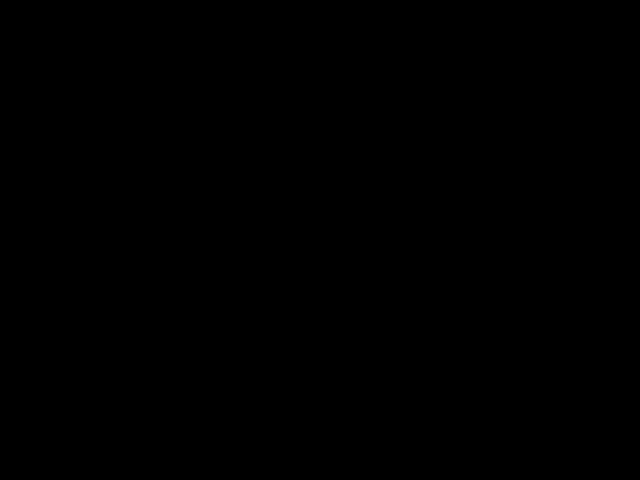

In [ ]:
## 画像表示のテスト
## 動画が表示されていればOK
## 適切に表示されない場合は，カメラの接続を確認すること．
## うまく表示されない場合の対処方法は，資料参照

image_show()

## 結果画像を表示させる場合は以下のように使う
## image_show(process, args)
## このとき，process は以下の形式を取る
## process(img, args) で結果画像を return
## 必ず2つの引数を持たなければならない，引数が不要の場合は以下のように初期値を与える（与えられない時，自動的にそれになる）
## process(img , args = [])
## 2つ以上の場合は，配列などで与える
## process(img, [theta, s, t]
## など．
## 以下の例で試してみること

In [ ]:
## BGR を RGBに変換して表示
def imshow(plt, img):
    plt.imshow(img[:,:,::-1])

width = 65
height = 85
channels = 3


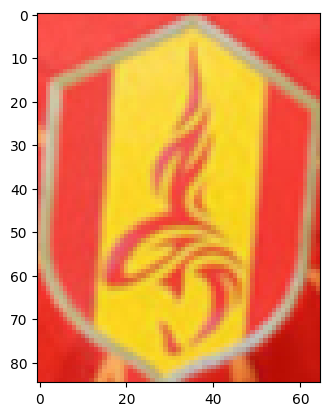

In [ ]:
## 画像を１枚取り込んで表示する．
## ここまでは共通

## 画像は numpy 形式で保持される．
#ret, src = cap.read()
src = cv2.imread("template.jpg")
ret = src is not None
## 画像の読み込みが成功した場合は ret に True が代入される．
if (ret == True):
    imshow(plt,src)
    ## 画像サイズ等の情報は，src.shape に記録されている
    ## numpy は行列（等）を保持する形式のため，[行（高さ），列（幅），チャネル数] の順番で保存される
    ## また，チャネル数とは画像がカラー画像の場合は3，グレースケール画像の場合は1となる．
    ## 詳しくは講義資料等を確認すること
    print("width = %d" % src.shape[1])
    print("height = %d" % src.shape[0])
    print("channels = %d" % src.shape[2])
    #cv2.imwrite('before_conversion_3.png', src)
else:
    print("Image cannot be captured. Check camera connection")


True

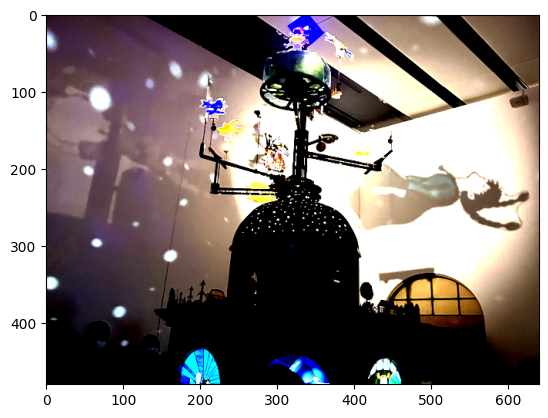

In [ ]:
## 課題　2-1
## 与えられたパラメタに従って線形のコントラスト補正を行うプログラムを作成せよ

def image_contrast_linear(src,args=[0, 255]):
    min, max = args[0], args[1]
    dst = np.zeros(src.shape,dtype=np.uint8)
    ## ここに適切なコードを記載せよ
    a = float(min)
    b = float(max)
    gm = 255.0 / (b - a)

    for x in range(src.shape[1]):
        for y in range(src.shape[0]):
            for c in range(src.shape[2]):
                z = src[y, x, c]
                if z < a:
                    dst[y, x, c] = 0
                elif z > b:
                    dst[y, x, c] = 255
                else:
                    dst[y, x, c] = np.uint8((z - a) * gm)
    return dst


dst = image_contrast_linear(src,[60,150])
imshow(plt, dst)
#cv2.imwrite('contrast_linear60to150.png', dst)

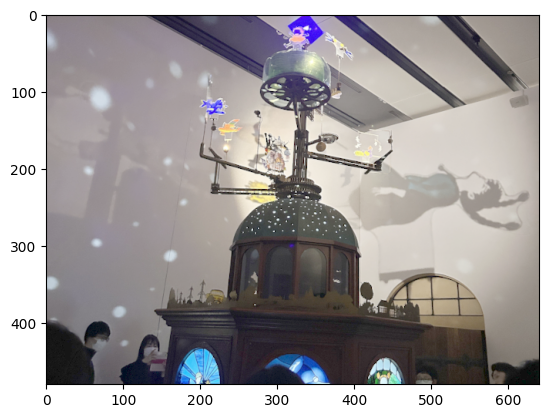

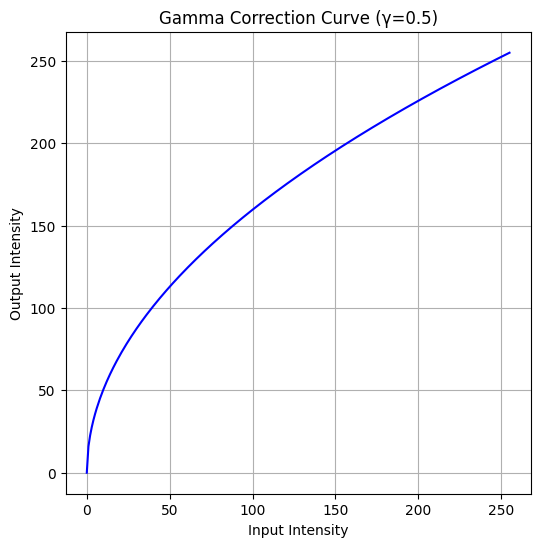

In [ ]:
## 課題　2-2
## 与えられたガンマ値に従って非線形コントラスト補正を実施するプログラムを作成せよ

def image_contrast_gamma(src, args=[1.0]):
    gamma = args[0]
    dst = np.zeros(src.shape,dtype=np.uint8)
    ## ここに適切なコードを記載せよ
    zm = 255.0

    for x in range(src.shape[1]):
        for y in range(src.shape[0]):
            for c in range(src.shape[2]):
                z = src[y, x, c] / zm
                dst[y, x, c] = np.uint8((z ** gamma) * zm)
    return dst

# ガンマ補正の適用（例：ガンマ値2.0）
gamma_value = 0.5
dst = image_contrast_gamma(src, [gamma_value])

imshow(plt, dst)
#cv2.imwrite('contrast_gamma0.5.png', dst)

#グラフ
x_values = np.linspace(0, 255, 256)
y_values = (x_values / 255.0) ** gamma_value * 255.0

plt.figure(figsize=(6, 6))
plt.plot(x_values, y_values, color='blue')
plt.title(f"Gamma Correction Curve (γ={gamma_value})")
plt.xlabel("Input Intensity")
plt.ylabel("Output Intensity")
plt.grid(True)
plt.show()

155


True

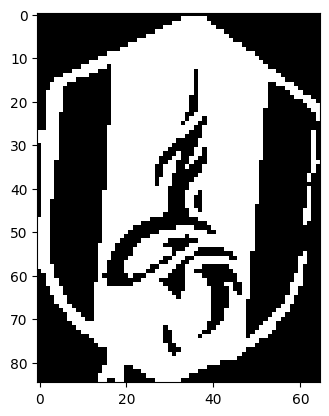

In [ ]:
## 課題　3
## 画像の２値化を実装し，その効果について確認せよ．

# 判別分析法
def calculate_thresh(src):
    gray = 0.299 * src[:, :, 2] + 0.587 * src[:, :, 1] + 0.114 * src[:, :, 0]
    gray = gray.astype(np.uint8)
    # ヒストグラムの計算
    hist, bins = np.histogram(gray, bins=256, range=(0, 256))
    total_pixels = gray.size
    max = 0
    thresh = 0
    sum_total = np.dot(hist, np.arange(256))
    sum_background = 0
    background = 0

    for t in range(256):
        background += hist[t]
        if background == 0:
            continue

        foreground = total_pixels - background
        if foreground == 0:
            break

        sum_background += t * hist[t]
        mean_background = sum_background / background
        mean_foreground = (sum_total - sum_background) / foreground

        # クラス間分散の計算
        variance_between = background * foreground * (mean_background - mean_foreground) ** 2

        # 最大のクラス間分散を記録
        if variance_between > max:
            max = variance_between
            thresh = t

    return thresh



# 各RGBに対して二値化処理
def image_binarize(src, args=[128.0]):
    thresh = args[0]
    dst = np.zeros(src.shape,dtype=np.uint8)
    ## ここに適切なコードを記載せよ
    for x in range(src.shape[1]):
        for y in range(src.shape[0]):
            r, g, b = src[y, x]
            if r > thresh and g > thresh and b > thresh:
                dst[y, x] = [255, 255, 255]
            else:
                dst[y, x] = [0, 0, 0]
    return dst

# グレースケールに変換したのちに
def image_binarize_grayscale(src, args = [128.0]):
    thresh = args[0]
    dst = np.zeros(src.shape, dtype= np.uint8)
    for x in range(src.shape[1]):
        for y in range(src.shape[0]):
            gray = 0.299 * src[y, x, 2] + 0.587 * src[y, x, 1] + 0.114 * src[y, x, 0]
            if gray > thresh:
                dst[y, x] = [255, 255, 255]
            else:
                dst[y, x] = [0, 0, 0]
    return dst

thesh_bin = calculate_thresh(src)
print(thesh_bin)
dst = image_binarize_grayscale(src, [161])
imshow(plt, dst)
cv2.imwrite('template_bin.jpg', dst)

In [ ]:
## 作成した関数を用いてリアルタイムでの動作を確認せよ
## image_show に与える関数を変化させて，動作を確認せよ．
## 下の例はコピーをそのまま表示

image_show(image_contrast_gamma, [1.0])